Enrico Convento --- id: 2023572

# Classification

The cells associated to the training have been disabled the weights associated can be found in the files:


*   fully_conn.pth
*   conv.pth
* dropout_cnet.pth

those file can be loaded in Colab in order to avoid to re-perform the training.


In [1]:
!pip install optuna

     |████████████████████████████████| 308 kB 12.5 MB/s 
     |████████████████████████████████| 80 kB 9.4 MB/s 
     |████████████████████████████████| 210 kB 45.1 MB/s 
     |████████████████████████████████| 75 kB 4.8 MB/s 
     |████████████████████████████████| 49 kB 6.1 MB/s 
     |████████████████████████████████| 113 kB 50.9 MB/s 
     |████████████████████████████████| 149 kB 48.5 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=2d0d2bd4fd991f2ab70fc6cefd431c064157a3c5e8ef652ce1c3291634c63851
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [2]:
# from google.colab import files # in order to be able to download and upload files

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from PIL import Image

from tqdm import tqdm # this module is useful to plot progress bars

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import torchvision

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix

import os
from tqdm.notebook import tqdm

from collections import OrderedDict

import optuna
#import noise
import plotly
from sklearn import metrics
import seaborn as sn

os.environ['CUDA_LAUNCH_BLOCKING'] = '1' # solving a bug of colab.
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}: {torch.cuda.get_device_name(0)}")

Training device: cuda: Tesla K80


#Dataset

In [3]:
# get the datasets

all_train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True)
all_test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True) 
raw = True

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to classifier_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting classifier_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to classifier_data/FashionMNIST/raw



Data set splitting in order to perform validation and test

In [4]:
val_perc = 0.2 # 20% validation data
shuffle = False

tr_list, val_list = train_test_split(all_train_dataset,test_size=val_perc, shuffle=shuffle) # create training and validation datasets

test_list = [sample for sample in all_test_dataset]

print('Training data:', len(tr_list), '\nValidation data:', len(val_list), '\nTest data: ', len(test_list))

Training data: 48000 
Validation data: 12000 
Test data:  10000


Data are stored in vector, a class to manage those kind of Dataset is build

In [5]:
class ListDataset(Dataset):
  '''
  Args:
    data_list: list with the data
    transform (callable, optional): Optional transform to be applied on a sample.
  '''
  def __init__(self, data_list, transform=None):
    self.transform = transform
    self.data = data_list

  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    sample = self.data[idx]
    if self.transform:
      sample = self.transform(sample)
    return sample

In [6]:
class ToTensor():
  '''
  Convert to tensor the image
  '''
  def __init__(self):
    self.t = transforms.ToTensor()

  def __call__(self, sample):
    pic, label = sample
    sample = (self.t(pic), label)
    return sample


class OneHotEncoder():
    '''
    Convert each encoded character in "sample" in a one-hot representation.
    INPUT
      e.g. 7
    OUTPUT
      ...0001000000 # all zeros but 1 at position 7.
    '''
    
    def __init__(self, alphabet_len):
      self.alphabet_len = alphabet_len
        
    def __call__(self, sample):
      pic, label = sample

      ### Create one hot matrix
      onehot = np.zeros(self.alphabet_len)
      onehot[label] = 1.

      sample = (pic, torch.tensor(onehot).float())
      return sample

ohe = OneHotEncoder(10)


train_transform = transforms.Compose([
    ToTensor(),
])
test_transform = transforms.Compose([
    ToTensor(),
    ohe,
])

In [7]:
if raw:
  all_train_dataset = ListDataset([sample for sample in all_train_dataset], train_transform)
  raw = False

train_dataset = ListDataset(tr_list, train_transform)
val_dataset = ListDataset(val_list, train_transform)
test_dataset = ListDataset(test_list, train_transform)

# Training 

In [8]:
class Training(object):
  '''
  Class for training the Network. This class is a starting point: to do more advanced stuff one can define new classes inheriting from this one.

  Args:
    net
    optimizer: needs to be already linked to the net
    loss_function
    train_dataloader: training Dataloader
    val_dataloader: validation Dataloader
  '''
  def __init__(self, net, optimizer, loss_function, train_dataloader, val_dataloader):
    self.net = net
    self.optimizer = optimizer
    self.loss_function = loss_function

    self.train_dataloader = train_dataloader
    self.val_dataloader = val_dataloader

    self.train_loss_log = []
    self.val_loss_log = []


  def stop_learning(self,epoch_num):
    return False


  def train_epoch(self):
    train_loss= []
    self.net.train() # Training mode
    for sample_batched in self.train_dataloader:
      # Move data to device
      x_batch = sample_batched[0].to(device)
      label_batch = sample_batched[1].to(device)
      # set previous gradients to 0
      self.optimizer.zero_grad()
      # Forward pass
      out = self.net(x_batch)
      # Compute loss
      loss = self.loss_function(out,label_batch)
      # Backpropagation
      loss.backward()
      # Update the weights
      self.optimizer.step()

      # Save train loss for this batch
      loss_batch = loss.detach().cpu().numpy()
      train_loss.append(loss_batch)

    # Save average train loss
    train_loss = np.mean(train_loss)
    return train_loss

  def val_epoch(self,dl):
    '''
    Args:
      dl: Dataloader on which to perform the test
    '''
    val_loss= []
    self.net.eval() # Evaluation mode
    with torch.no_grad(): # Disable gradient tracking
      for sample_batched in dl:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)
        # Forward pass
        out = self.net(x_batch)
        # Compute loss
        loss = self.loss_function(out,label_batch)
        # Save val loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        val_loss.append(loss_batch)

      # Save average validation loss
      val_loss = np.mean(val_loss)
      return val_loss

  def train(self,num_epochs,verbose=False):

    ### TRAINING LOOP
    for epoch_num in tqdm(range(num_epochs)):
      if verbose:
        print('#################')
        print(f'# EPOCH {epoch_num}')

      ### TRAIN
      train_loss = self.train_epoch()
      if verbose:
        print(f"AVERAGE TRAIN LOSS: {train_loss}")
      self.train_loss_log.append(train_loss)

      ### VALIDATION
      val_loss = self.val_epoch(self.val_dataloader)
      if verbose:
        print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
      self.val_loss_log.append(val_loss)

      if self.stop_learning(epoch_num):
        break
        

  def plot_losses(self,avg_size=10):
    '''
    Plots the behavior of the train and val losses and prints their average in the last 'avg_size' epochs
    Args:
      avg_size: int
    '''
    plt.figure(figsize=(12,8))
    plt.semilogy(self.train_loss_log, label='Training loss')
    plt.semilogy(self.val_loss_log, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    plt.show()

    print('Average traininig  loss in the last %d epochs: %.4f' %(avg_size, np.mean(self.train_loss_log[-avg_size:])))
    print('Average validation loss in the last %d epochs: %.4f' %(avg_size, np.mean(self.val_loss_log[-avg_size:])))


  def test(self,test_dataset):
    '''
    Args:
      test_dataset: Dataset with data on which to perform the test
    '''
    test_dataloader = DataLoader(test_dataset,batch_size=256,shuffle=False,num_workers=0)
    return self.val_epoch(test_dataloader)

  

In [9]:
class Training_es(Training):

  def __init__(self, patience, best_vl=10, *args, **kwargs):
    '''
    *** Training with early stopping ***
    Args:
      patience: int: if after patience epochs the validation loss does not decrease learning stops

      *args, **kwargs: arguments of the parent class
    '''
    super().__init__(*args, **kwargs)

    self.patience = patience
    self.counter = 0
    self.best_vl = best_vl

  def stop_learning(self,epoch_num):
    if epoch_num <= self.patience: # at least do 'patience' epochs
      return False

    if self.val_loss_log[-1] < self.best_vl:
      self.best_vl = self.val_loss_log[-1]
      self.counter =0

    else:
      self.counter += 1

    if self.counter >= self.patience:
      print('---> Early stopping')
      return True



# Fully connected

In [10]:
class FC_net(nn.Module):
  def __init__(self, Ni, Nh1, Nh2, No, activation_function=nn.ReLU(), o_act=nn.Identity()):
    '''
    Network with 2 hidden linear layers
    '''
    super().__init__()

    self.flatten = nn.Flatten(start_dim=1)

    self.fc1 = nn.Linear(in_features=Ni,out_features=Nh1)
    self.fc2 = nn.Linear(in_features=Nh1,out_features=Nh2)
    self.out = nn.Linear(in_features=Nh2,out_features=No)

    self.act = activation_function
    self.o_act = o_act


  def forward(self, x):

    x = self.flatten(x)
    x = self.act(self.fc1(x))
    x = self.act(self.fc2(x))
    x = self.o_act(self.out(x)) # use a sigmoid to force the output layer to have values between 0 and 1

    return x

In [11]:
Ni = 28*28
Nh1 = 128
Nh2 = 16
No = 10
activation_function = nn.ReLU()
o_act = nn.Sigmoid()

# torch.manual_seed(0)

net = FC_net(Ni,Nh1,Nh2,No,activation_function=activation_function, o_act=o_act).to(device)
print('\n######################\n\n NETWORK STRUCTURE \n\n', net, '\n\n######################')

optimizer = optim.Adam(net.parameters(),lr=0.001,weight_decay=0)

loss_function = nn.CrossEntropyLoss()

train_batch_size = 256
val_batch_size = 256

patience = 10

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False, num_workers=0)


trainer = Training_es(patience=patience,net=net,optimizer=optimizer,loss_function=loss_function,
                    train_dataloader=train_dataloader,val_dataloader=val_dataloader)


######################

 NETWORK STRUCTURE 

 FC_net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=16, bias=True)
  (out): Linear(in_features=16, out_features=10, bias=True)
  (act): ReLU()
  (o_act): Sigmoid()
) 

######################


  0%|          | 0/40 [00:00<?, ?it/s]

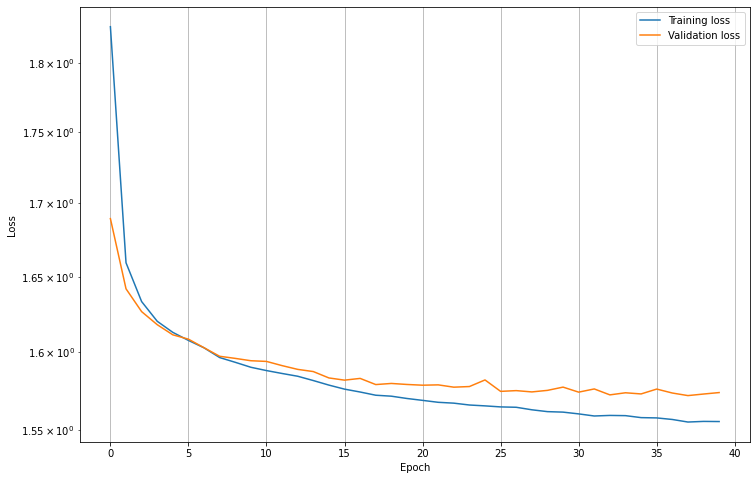

Average traininig  loss in the last 10 epochs: 1.5577
Average validation loss in the last 10 epochs: 1.5739


In [ ]:
#trainer.train(40,verbose= False)

#trainer.plot_losses()

In [12]:

## Saving model ##
#torch.save(trainer.net.state_dict(), 'fully_conn.pth')

## Load model ##
net.load_state_dict(torch.load('fully_conn.pth'))

<All keys matched successfully>

## Parameter exploration

In [13]:
class KFoldCrossValidator(object):
  '''
  Performs a k fold cross validation on a specific set of hyperparameters

  Args:
    k: int, number of folds
    n_runs: int or None: if n_runs < k, only the first n_runs will be performed.
            This is a quick workaround to speed up the hyperparameter optimization process
    shuffle: bool: if true data is shuffled before the splitting in k folds
    all_train_dataset: Dataset with train and validation data that will be split in folds

    net_type: user defined class
    net_params: dictionary or list of the arguments for net_type.__init__

    optimizer_type: e.g. optim.Adam
    optimizer_params: dictionary or list of the arguments of the optimizer (except net.parameters())

    loss_function
    train_batch_size: int, default 256

    trainer_type: e.g. Trainer or Trainer_es
    trainer_additional_params: dictionary with additional parameters for the evolver,
      e.g. if trainer_type = Trainer_es, the additional parameter 'patience' must be provided
  '''

  def __init__(self, k, n_runs=None, shuffle=False, all_train_dataset=None, net_type=None, net_params=None,
               optimizer_type=None, optimizer_params=None, loss_function=None,
               train_batch_size=256, trainer_type=None, trainer_additional_params={}):

    self.splitter = KFold(k,shuffle=shuffle)

    self.all_train_dataset = all_train_dataset

    self.net_type = net_type
    self.net_params = net_params
    self.optimizer_type = optimizer_type
    self.optimizer_params = optimizer_params

    self.train_batch_size = train_batch_size

    self.loss_function = loss_function

    self.trainer_type = trainer_type
    self.trainer_additional_params = trainer_additional_params

    self.trainers = []

    # set up the object with k (or n_runs) trainers
    i = 0
    for train_idx, val_idx in self.splitter.split(list(range(len(self.all_train_dataset)))):
      # datasets
      train_dataset = Subset(self.all_train_dataset, train_idx)
      val_dataset = Subset(self.all_train_dataset, val_idx)

      # dataloaders
      train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=0)
      val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=0)

      # net
      if type(self.net_params) == dict:
        net = self.net_type(**self.net_params)
      else:
        net = self.net_type(*self.net_params)

      # optimizer
      if type(self.optimizer_params) == dict:
        optimizer = self.optimizer_type(net.parameters(),**self.optimizer_params)
      else:
        optimizer = self.optimizer_type(net.parameters(),*self.optimizer_params)

      # trainer
      trainer = self.trainer_type(net=net,optimizer=optimizer,loss_function=loss_function,
                                  train_dataloader=train_dataloader,val_dataloader=val_dataloader, **self.trainer_additional_params)

      self.trainers.append(trainer)

      i += 1
      if n_runs is not None and i >= n_runs:
        break


  def run(self,num_epochs,loss_sample_size=10, prune_thr=None):
    '''
    Args:
      num_epochs: maximum number of epochs for each fold
      loss_sample_size: number of epochs for computing the average train and val losses, default 10
      prune_thr: folat or None: if one of the final validation losses is > prune thr, the run is interrupted raising a ValueError
    '''
    for k,trainer in enumerate(self.trainers):
      # move the net to the GPU
      trainer.net.to(device)
      trainer.train(num_epochs)
      # move the net back to free the GPU
      trainer.net.cpu()
      if prune_thr is not None and k < len(self.trainers)/2 and trainer.val_loss_log[-1] > prune_thr:
        print(f'Trial pruned: val loss was {trainer.val_loss_log[-1]}')
        raise ValueError


      # print avg train and val loss
      #print(np.mean(trainer.train_loss_log[-loss_sample_size:]), np.mean(trainer.val_loss_log[-loss_sample_size:]))

    avg_train_loss = np.mean([np.mean(e.train_loss_log[-loss_sample_size:]) for e in self.trainers])
    avg_val_loss   = np.mean([np.mean(e.val_loss_log[-loss_sample_size:]) for e in self.trainers])
    print('\n\nResults')
    print(f'### Average train loss: {avg_train_loss}')
    print(f'### Average validation loss: {avg_val_loss}\n\n')
    
    return avg_train_loss, avg_val_loss
    

### Learing rate

In [ ]:

k = 5
runs = 1

net_type = FC_net
optimizer_type = optim.Adam

net_params = {'Ni' : 28*28, 'Nh1' : 128,'Nh2' : 16,'No' : 10,
                  'activation_function' : nn.ReLU(), 'o_act' : nn.Sigmoid()}

name = 'classification - Learning rate'
loss_function = nn.CrossEntropyLoss()

train_batch_size = 256

trainer_type = Training_es
trainer_additional_params = {'patience': 10} # no checkpoint to speed up the training

def objective(trial):


  lr = trial.suggest_float("learning rate", 1e-5, 3)

  hyperparameters = dict(lr = lr)
  optimizer_params = {'lr': lr}
  # KFold

  kf = KFoldCrossValidator(k, shuffle=True, all_train_dataset=all_train_dataset, net_type=net_type, net_params=net_params,
                        optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                        train_batch_size=train_batch_size, trainer_type=trainer_type, trainer_additional_params=trainer_additional_params)

  train_loss, val_loss = kf.run(40)


  return val_loss
    



pruner: optuna.pruners.BasePruner = optuna.pruners.NopPruner()

study = optuna.create_study(direction="minimize", pruner=pruner, study_name = 'Learning rate ')
study.optimize(objective, n_trials=10, timeout=150)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))



[I 2022-02-07 07:29:32,809] A new study created in memory with name: Learning rate 


  0%|          | 0/40 [00:00<?, ?it/s]

---> Early stopping


  0%|          | 0/40 [00:00<?, ?it/s]

---> Early stopping


  0%|          | 0/40 [00:00<?, ?it/s]

---> Early stopping


  0%|          | 0/40 [00:00<?, ?it/s]

---> Early stopping


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-02-07 07:41:26,627] Trial 0 finished with value: 2.390097141265869 and parameters: {'learning rate': 2.2813455026531653}. Best is trial 0 with value: 2.390097141265869.


---> Early stopping


Results
### Average train loss: 2.387690305709839
### Average validation loss: 2.390097141265869


Number of finished trials: 1
Best trial:
  Value: 2.390097141265869
  Params: 
    learning rate: 2.2813455026531653


### L2 regularization

In [ ]:

k = 5
runs = 1

net_type = FC_net
optimizer_type = optim.Adam

net_params = {'Ni' : 28*28, 'Nh1' : 128,'Nh2' : 16,'No' : 10,
                  'activation_function' : nn.ReLU(), 'o_act' : nn.Sigmoid()}

name = 'classification - Learning rate'
loss_function = nn.CrossEntropyLoss()

train_batch_size = 256

trainer_type = Training_es
trainer_additional_params = {'patience': 10} # no checkpoint to speed up the training

def objective(trial):


  weight_decay = trial.suggest_loguniform("weight_decay", 1e-4, 1e-2)

  hyperparameters = dict(weight_decay = weight_decay)
  optimizer_params = {'lr': 0.005, 'weight_decay': weight_decay}    # KFold
  # KFold

  kf = KFoldCrossValidator(k, shuffle=True, all_train_dataset=all_train_dataset, net_type=net_type, net_params=net_params,
                        optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                        train_batch_size=train_batch_size, trainer_type=trainer_type, trainer_additional_params=trainer_additional_params)

  train_loss, val_loss = kf.run(40)


  return val_loss
    



pruner: optuna.pruners.BasePruner = optuna.pruners.NopPruner()

study = optuna.create_study(direction="minimize", pruner=pruner, study_name = 'Learning rate ')
study.optimize(objective, n_trials=10, timeout=150)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))



[I 2022-02-07 07:41:27,579] A new study created in memory with name: Learning rate 


  0%|          | 0/40 [00:00<?, ?it/s]

---> Early stopping


  0%|          | 0/40 [00:00<?, ?it/s]

---> Early stopping


  0%|          | 0/40 [00:00<?, ?it/s]

---> Early stopping


  0%|          | 0/40 [00:00<?, ?it/s]

---> Early stopping


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2022-02-07 07:56:36,620] Trial 0 finished with value: 1.6738907098770142 and parameters: {'weight_decay': 0.00421502342034428}. Best is trial 0 with value: 1.6738907098770142.




Results
### Average train loss: 1.672795295715332
### Average validation loss: 1.6738907098770142


Number of finished trials: 1
Best trial:
  Value: 1.6738907098770142
  Params: 
    weight_decay: 0.00421502342034428


## Optimizer

In [ ]:
def configure_optimizers(opt , momentum, weight_decay = 0 ,  lr = 0.01):
        if opt == 'Adam':
          optimizer = optim.Adam
          optimizer_params = {'lr':lr, 'weight_decay':weight_decay}
        elif opt == 'SGD':
          optimizer = optim.SGD
          optimizer_params = {'lr':lr, 'weight_decay':weight_decay}
        elif opt == 'momentumSGD':
          optimizer = optim.SGD
          optimizer_params = {'lr':lr, 'weight_decay':weight_decay, 'momentum': momentum}
        elif opt == 'RMSprop':
          optimizer = optim.RMSprop
          optimizer_params = {'lr':lr, 'weight_decay':weight_decay, 'momentum': momentum}
        else: 
          print("Default optimizer : Adam")
          optimizer = optim.Adam
          optimizer_params = {'lr':lr, 'weight_decay':weight_decay}
        return optimizer, optimizer_params

In [ ]:
k = 5
runs = 1

net_type = FC_net
optimizer_type = optim.Adam

net_params = {'Ni' : 28*28, 'Nh1' : 128,'Nh2' : 16,'No' : 10,
                  'activation_function' : nn.ReLU(), 'o_act' : nn.Sigmoid()}

name = 'classification - Learning rate'
loss_function = nn.CrossEntropyLoss()

train_batch_size = 256

trainer_type = Training_es
trainer_additional_params = {'patience': 10} # no checkpoint to speed up the training

def objective(trial):


  # optimizer params
    optimizer = trial.suggest_categorical('optimizer', ['SGD', 'Adam', 'momentumSGD', 'RMSprop'])
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-4, 1e-1)
    momentum = trial.suggest_float("momentum", 0.2, 0.8)
    lr = trial.suggest_loguniform("learning rate", 1e-5, 1e-2)

    optimizer_type, optimizer_params = configure_optimizers(optimizer, weight_decay, momentum, lr)
    

    hyperparameters = dict(weight_decay = weight_decay)

    kf = KFoldCrossValidator(k, shuffle=True, all_train_dataset=all_train_dataset, net_type=net_type, net_params=net_params,
                          optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                          train_batch_size=train_batch_size, trainer_type=trainer_type, trainer_additional_params=trainer_additional_params)

    train_loss, val_loss = kf.run(100)


    return val_loss
    



pruner: optuna.pruners.BasePruner = optuna.pruners.NopPruner()

study = optuna.create_study(direction="minimize", pruner=pruner, study_name = 'Learning rate ')
study.optimize(objective, n_trials=10, timeout=150)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-02-07 07:56:36,704] A new study created in memory with name: Learning rate 


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-07 08:10:30,140] Trial 0 finished with value: 2.302119731903076 and parameters: {'optimizer': 'momentumSGD', 'weight_decay': 0.0025269766959614658, 'momentum': 0.7127318413304471, 'learning rate': 0.00017275150401082387}. Best is trial 0 with value: 2.302119731903076.


---> Early stopping


Results
### Average train loss: 2.3021063804626465
### Average validation loss: 2.302119731903076


Number of finished trials: 1
Best trial:
  Value: 2.302119731903076
  Params: 
    optimizer: momentumSGD
    weight_decay: 0.0025269766959614658
    momentum: 0.7127318413304471
    learning rate: 0.00017275150401082387


## Test 

t-shirt with probability:  7.495607e-10
trouser with probability:  1.000000e+00
pullover with probability:  2.556427e-10
dress with probability:  2.611744e-05
coat with probability:  4.783907e-12
sandal with probability:  3.582503e-23
shirt with probability:  4.554909e-21
sneaker with probability:  5.011439e-11
bag with probability:  2.530304e-18
boot with probability:  1.780665e-10


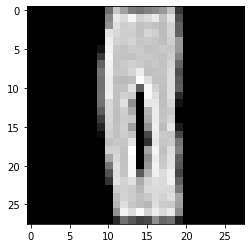

In [14]:
# test on one sample
cm_dataset =test_dataset
cm_dataset.transform = train_transform

idx = 47

sample = cm_dataset[idx]

pic, label = sample

pic = pic.to(device)
label = label

net.eval()
with torch.no_grad():
  y = net(pic)

label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']
for i,v in enumerate(y.squeeze()):
  print(label_names[i], 'with probability: ', "{:e}".format(v.item()))


# plt.imshow(img.cpu().squeeze().numpy(), cmap='gray')
plt.figure()
plt.imshow(np.array(pic.squeeze().cpu()), cmap='gist_gray')

## Accuracy and confusion matrix

Network accuracy: 0.8611


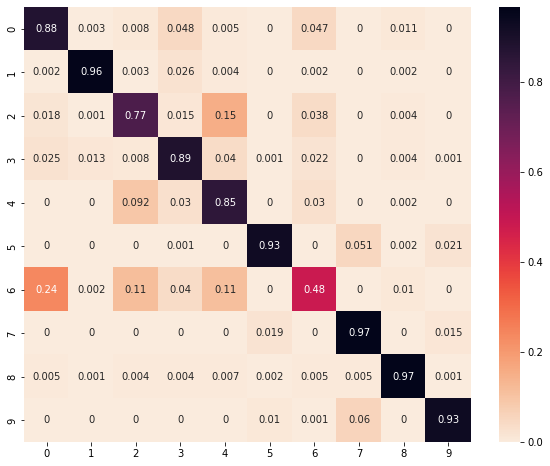

In [15]:
cm_dataset = test_dataset
cm_dataset.transform = train_transform
cm_dataloader = DataLoader(test_dataset,batch_size=256,shuffle=False,num_workers=0)

net_outputs = np.array([])
labels = np.array([])

net.eval()
with torch.no_grad():
  for batch in cm_dataloader:
    out = torch.argmax(net(batch[0].to(device)), dim=1).cpu().numpy()
    label = batch[1].squeeze().cpu().numpy()
    

    net_outputs = np.concatenate([net_outputs, out])
    labels = np.concatenate([labels, label])

net_outputs = np.array(net_outputs, dtype=int)
labels = np.array(labels, dtype=int)
cm = metrics.confusion_matrix(labels, net_outputs)
# Show the confusion matrix
fig = plt.figure(figsize=(10,8))
sn.heatmap(cm/np.sum(cm)*10, annot=True, cmap='rocket_r')
accuracy = np.mean(net_outputs == labels)

print('Network accuracy:', accuracy)



## Visualization

### Weights

In [16]:
net = trainer.net
print(net)

FC_net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=16, bias=True)
  (out): Linear(in_features=16, out_features=10, bias=True)
  (act): ReLU()
  (o_act): Sigmoid()
)


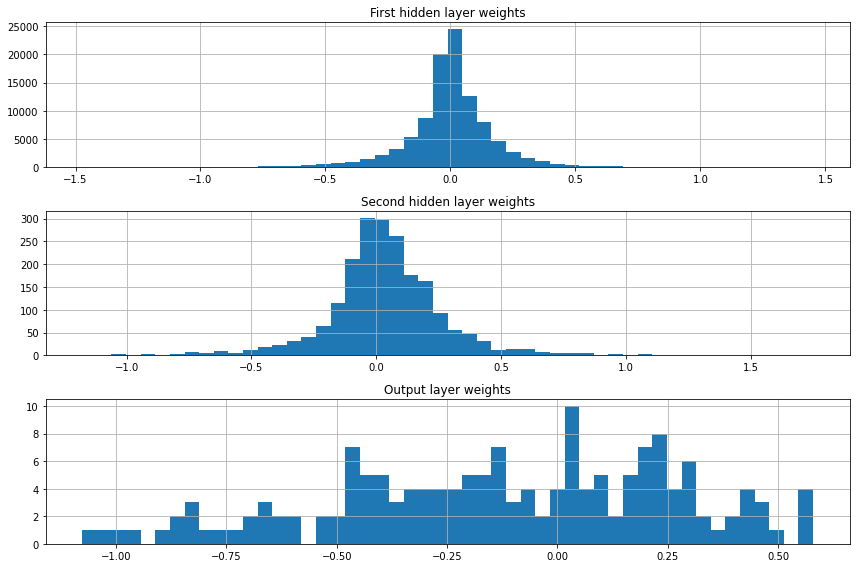

In [17]:
h1_w = net.fc1.weight.data.cpu().numpy()
h2_w =  net.fc2.weight.data.cpu().numpy()
out_w = net.out.weight.data.cpu().numpy()

# Weights histogram
fig, axs = plt.subplots(3, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights')
axs[2].hist(out_w.flatten(), 50)
axs[2].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

### Activations

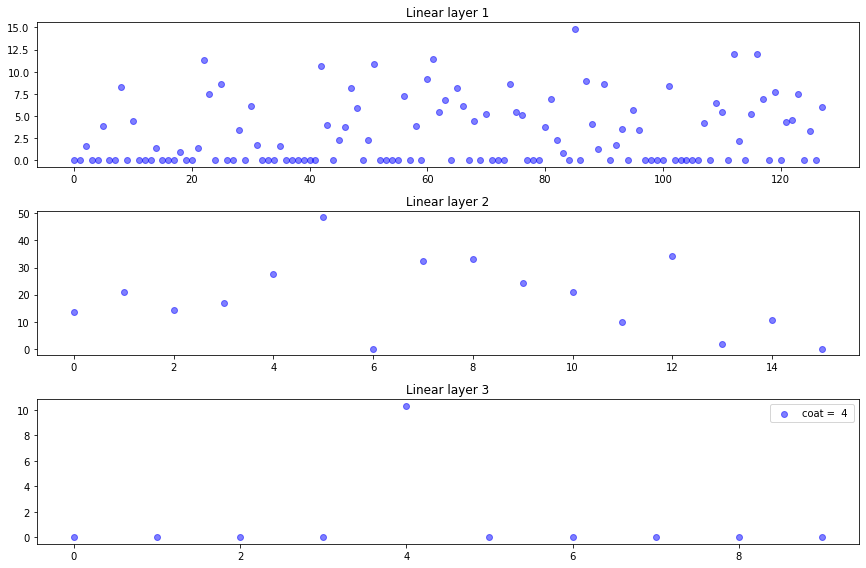

In [18]:
test_dataset.transform = train_transform
#define a hook for each layer
idx = 50

pic = test_dataset[idx][0].unsqueeze(0).to(device)

label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']
label = label_names[test_dataset[idx][1]]



def get_activation1(layer, input, output):
    global activation1 # define global variable in which to store the activations.
    activation1 = torch.relu(output)

hook_handle1 = net.fc1.register_forward_hook(get_activation1)

def get_activation2(layer, input, output):
    global activation2 # define global variable in which to store the activations.
    activation2 = torch.relu(output)

hook_handle2 =  net.fc2.register_forward_hook(get_activation2)

def get_activation3(layer, input, output):
    global activation3 # define global variable in which to store the activations.
    activation3 = torch.relu(output)

hook_handle3 = net.out.register_forward_hook(get_activation3)

# evaluate the net
net.to(device)
net.eval()
with torch.no_grad():
    y = net(pic).to(device)

    a1 = activation1.cpu().numpy()
    a2 = activation2.cpu().numpy()
    a3 = activation3.cpu().numpy()


a_s = [a1,a2,a3]

# remove hooks
hook_handle1.remove()
hook_handle2.remove()
hook_handle3.remove()

#plot activations
fig, axs = plt.subplots(3,1, figsize=(12,8))
for i,a in enumerate(a_s):
  axs[i].scatter(np.arange(len(a[0])), a,label=f'{label} =  {test_dataset[idx][1]} ',color='blue', alpha=0.5)
  axs[i].set_title(f'Linear layer {i + 1}')


plt.legend()

fig.tight_layout()

## Activation Maximization

In [19]:
print(net)

FC_net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=16, bias=True)
  (out): Linear(in_features=16, out_features=10, bias=True)
  (act): ReLU()
  (o_act): Sigmoid()
)


In [20]:
# Freeze the parameters of the trained model
for param in net.parameters():
    param.requires_grad = False

# Rregister a forward hook to get the output of the layers

activation = {} # store the activation  of a layer
def create_hook(name):
    def hook(m, i, o):
        activation[name] = o
       
    return hook


# register a forward hook for layer choosen 
hook_handle = net.out.register_forward_hook(create_hook('out'))

img_shape:torch.Size([1, 28, 28]), img_dtype: torch.float32


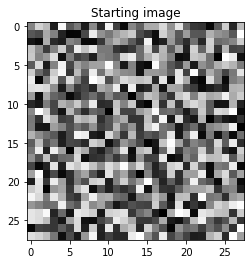

In [21]:
normalize = transforms.Normalize(mean=[0.485],
                                 std=[0.229])

denormalize = transforms.Normalize(mean = [-0.485/0.229],
                                   std = [1/0.229] )

# function to create an image with random pixels 
def random_image(h = 28, w = 28, device = 'cpu', requires_grad=False, optimizer=None, lr = 0.01):
    img = np.single(np.random.uniform(0,1, (1, h, w)))
    im_tensor = normalize(torch.from_numpy(img)).to(device).requires_grad_(requires_grad) # normalize 
    print("img_shape:{}, img_dtype: {}".format(im_tensor.shape, im_tensor.dtype ))
    
    if optimizer:
        if requires_grad:
            return im_tensor, optimizer([im_tensor], lr = lr)
        else: 
            print('Error: Optimizer cannot be used on an image without setting its requires_grad_  ')
    
    return im_tensor
# Convert 'tensor' image in image for visualization
def image_converter(im):
    
    im_copy = im.cpu()
    im_copy = denormalize(im_copy.clone().detach()).numpy().transpose(1,2,0)
    im_copy = im_copy.clip(0, 1) 
    
    return im_copy
    
H = 28 # height of input image
W = 28 # width of input image
img_tensor, optimizer = random_image(h = H, w = W, device = device, 
                                     requires_grad = True, optimizer = optim.Adam, lr = 0.01)
plt.imshow((image_converter(img_tensor)).squeeze(), cmap='gist_gray')
plt.title('Starting image')
plt.show()

Epoch: 0/10000, Index: 17.567909240722656


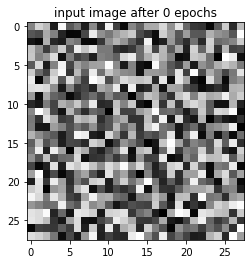

Epoch: 1000/10000, Index: 5242.513671875


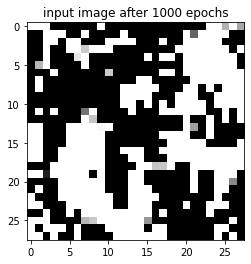

Epoch: 2000/10000, Index: 10576.3125


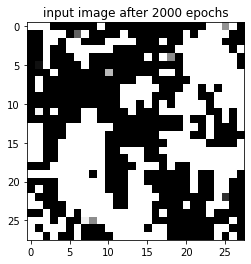

Epoch: 3000/10000, Index: 15931.935546875


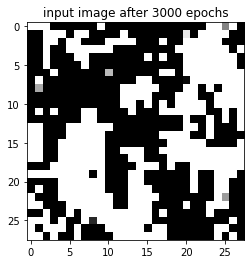

Epoch: 4000/10000, Index: 21308.390625


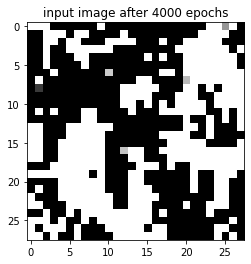

Epoch: 5000/10000, Index: 26699.10546875


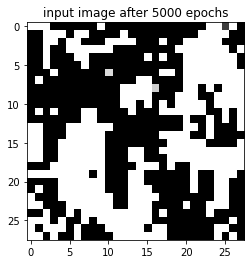

Epoch: 6000/10000, Index: 32096.990234375


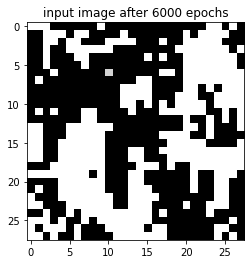

Epoch: 7000/10000, Index: 37494.5703125


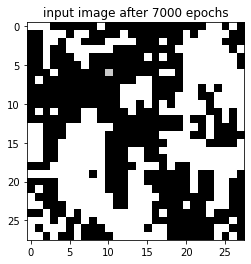

Epoch: 8000/10000, Index: 42892.30859375


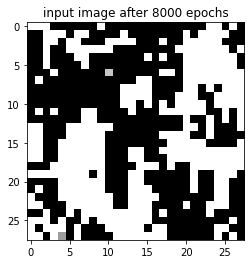

Epoch: 9000/10000, Index: 48290.08203125


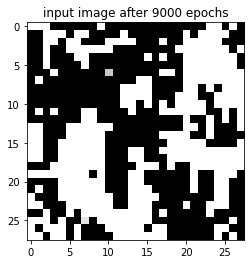

In [22]:
net.eval()
net.o_act = nn.Identity()
num_epochs = 10000
display_every = 1000
unit_idx = 5 # unit of the convolution layer that we wish to visualize

for epoch in range(num_epochs):
    
    optimizer.zero_grad()
    net(img_tensor.unsqueeze(0))
    layer = activation['out']
    loss = -layer[0, unit_idx].mean() 
    loss.backward()
    optimizer.step()
 
    
    if epoch % display_every == 0:
        print('Epoch: {}/{}, Index: {}'.format(epoch, num_epochs, -loss))
        plt.imshow((image_converter(img_tensor)).squeeze(), cmap='gist_gray')
        plt.title('input image after {} epochs'.format(epoch))
        plt.show()

hook_handle.remove()

In [23]:
y = torch.softmax(net(img_tensor), dim = 1)
y = y.squeeze().detach().cpu().numpy()
net.o_act = nn.Sigmoid()
for i,yv in enumerate(y):
  print(f'{i}: {yv}')

0: 0.0
1: 0.0
2: 0.0
3: 0.0
4: 0.0
5: 1.0
6: 0.0
7: 0.0
8: 0.0
9: 0.0


# Convolutional network

In [24]:
class Conv_net(nn.Module):
  '''
  Convolutional neural network
  '''

  def __init__(self, channels=[], kernel_sizes=[], strides=[], paddings=[], Nhs=[], activation_function=nn.ReLU, No=10, o_act=nn.Identity()):
    '''
    Params of the convolutional layers: the following should be lists of int and be of the same lenght
      channels
      kernel_sizes
      strides
      paddings

    Params of the linear layers:
      Nhs: list of int: numbers of neurons per linear layer
      No: number of output neurons
    
    Activation functions:
      activation_function: default nn.ReLU (beware NOT nn.ReLU()): activation function between all the hidden layers
      o_act: default nn.Identity(): activation function after the output layer
    '''
    super().__init__()

    self.shapes = [(1, 28, 28)]

    ### Convolutional layer

    ## Create an ordered dictionary with the layers
    self.conv_od = OrderedDict([])
    for i,c in enumerate(channels):
      # add convolutional layer
      if i == 0:
        self.conv_od.update({'conv1': nn.Conv2d(in_channels=1,out_channels=channels[0],
                                                       kernel_size=kernel_sizes[0], stride = strides[0], padding=paddings[0])})
      else:
        self.conv_od.update({f'conv{i + 1}': nn.Conv2d(in_channels=channels[i - 1],out_channels=c,
                                                       kernel_size=kernel_sizes[i], stride = strides[i], padding=paddings[i])})
      self.shapes.append((c, self.shapes[-1][1]//strides[i], self.shapes[-1][2]//strides[i]))
      # add activation function
      self.conv_od.update({f'conv_act{i + 1}': activation_function()})

    ## Create a sequential layer
    self.conv_layers = nn.Sequential(self.conv_od)


    ### Flatten

    self.flatten = nn.Flatten(start_dim=1)
    self.shapes.append(np.product(self.shapes[-1]))


    ### Linear fc layers

    ## Create ordered dictionary with the layers
    self.lin_od = OrderedDict([])
    Nhs = [self.shapes[-1]] + Nhs
    for i in range(1,len(Nhs)):
      # add linear layer
      self.lin_od.update({f'lin{i}': nn.Linear(in_features=Nhs[i - 1], out_features=Nhs[i])})
      self.shapes.append(Nhs[i])

      # add activation function
      self.lin_od.update({f'lin_act{i}': activation_function()})

    ## Create a sequential layer
    self.lin_layers = nn.Sequential(self.lin_od)


    ## Create the output layer
    self.out = nn.Linear(in_features=Nhs[-1], out_features=No)
    self.o_act = o_act


  def forward(self, x):
    # apply convolutional layers
    x = self.conv_layers(x)

    # flatten
    x = self.flatten(x)

    # apply linear layers
    x = self.lin_layers(x)

    # output layer
    x = self.o_act(self.out(x))
    return x

In [25]:
# testing
channels = [8,16,32]
kernel_sizes = [3,3,3]
strides = [2,2,2]
paddings = [1,1,0]

Nhs = [128, 16]

cnet = Conv_net(channels=channels, kernel_sizes=kernel_sizes, strides=strides, paddings=paddings,
             Nhs=Nhs).to(device)

optimizer = optim.Adam(cnet.parameters(),lr=0.001,weight_decay=1e-4)

loss_function = nn.CrossEntropyLoss()

train_batch_size = 256
val_batch_size = 256

patience = 10

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False, num_workers=0)


trainer = Training_es(patience=patience,net=cnet,optimizer=optimizer,loss_function=loss_function,
                    train_dataloader=train_dataloader,val_dataloader=val_dataloader)
trainer.net.o_act = nn.Sigmoid()

  0%|          | 0/40 [00:00<?, ?it/s]

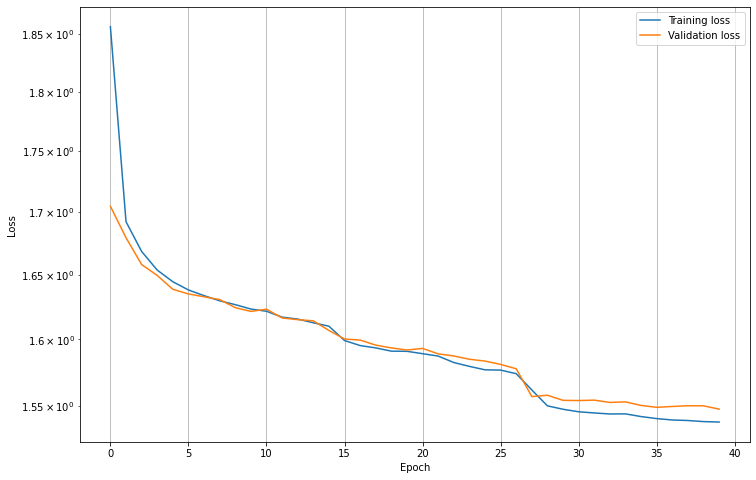

Average traininig  loss in the last 10 epochs: 1.5419
Average validation loss in the last 10 epochs: 1.5512


In [ ]:
#trainer.train(40,verbose= False)

#trainer.plot_losses()

In [26]:

## Saving model ##
#torch.save(trainer.net.state_dict(), 'conv.pth')

## Load model ##
cnet.load_state_dict(torch.load('conv.pth'))

<All keys matched successfully>

## Accuracy and confusion matrix

Network accuracy: 0.8905


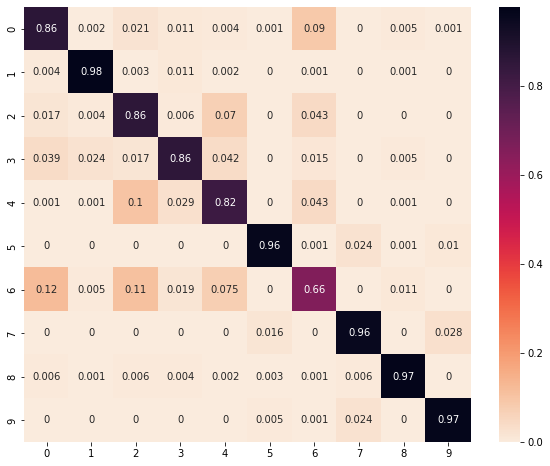

In [27]:
cm_dataset = test_dataset
cm_dataset.transform = train_transform
cm_dataloader = DataLoader(cm_dataset,batch_size=256,shuffle=False,num_workers=0)

net_outputs = np.array([])
labels = np.array([])

cnet.eval()
with torch.no_grad():
  for batch in cm_dataloader:
    out = torch.argmax(cnet(batch[0].to(device)), dim=1).cpu().numpy()
    label = batch[1].squeeze().cpu().numpy()

    net_outputs = np.concatenate([net_outputs, out])
    labels = np.concatenate([labels, label])

net_outputs = np.array(net_outputs, dtype=int)
labels = np.array(labels, dtype=int)
cm = confusion_matrix(labels, net_outputs)
# Show the confusion matrix
fig = plt.figure(figsize=(10,8))
sn.heatmap(cm/np.sum(cm)*10, annot=True, cmap='rocket_r')
accuracy = np.mean(net_outputs == labels)

print('Network accuracy:', accuracy)

## Visualization

### Weights

In [40]:
print(cnet)

Conv_net(
  (conv_layers): Sequential(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv_act1): ReLU()
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv_act2): ReLU()
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (conv_act3): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lin_layers): Sequential(
    (lin1): Linear(in_features=288, out_features=128, bias=True)
    (lin_act1): ReLU()
    (lin2): Linear(in_features=128, out_features=16, bias=True)
    (lin_act2): ReLU()
  )
  (out): Linear(in_features=16, out_features=10, bias=True)
  (o_act): Sigmoid()
)


In [41]:
def plot_nchw_data(data, h_num=None, v_num=None, title=None):
    shape = data.shape
    data = data.reshape(shape[0]*shape[1], shape[2], shape[3])
    if h_num is None or v_num is None:
      n = shape[0]*shape[1]
      h_num = int(np.sqrt(n)) + 1
      v_num = n//h_num + 1
    # print(h_num, v_num)
    fig, axs = plt.subplots(v_num, h_num, figsize=(h_num,v_num))
    for idx, ax in enumerate(axs.flatten()):
        ax.set_xticks([])
        ax.set_yticks([])
        if idx < len(data):
            ax.imshow(data[idx,:,:], cmap='gray')
    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0, 1, 0.97], h_pad=0, w_pad=0)
    plt.show()

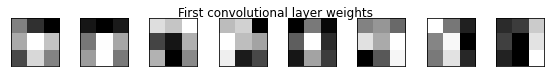

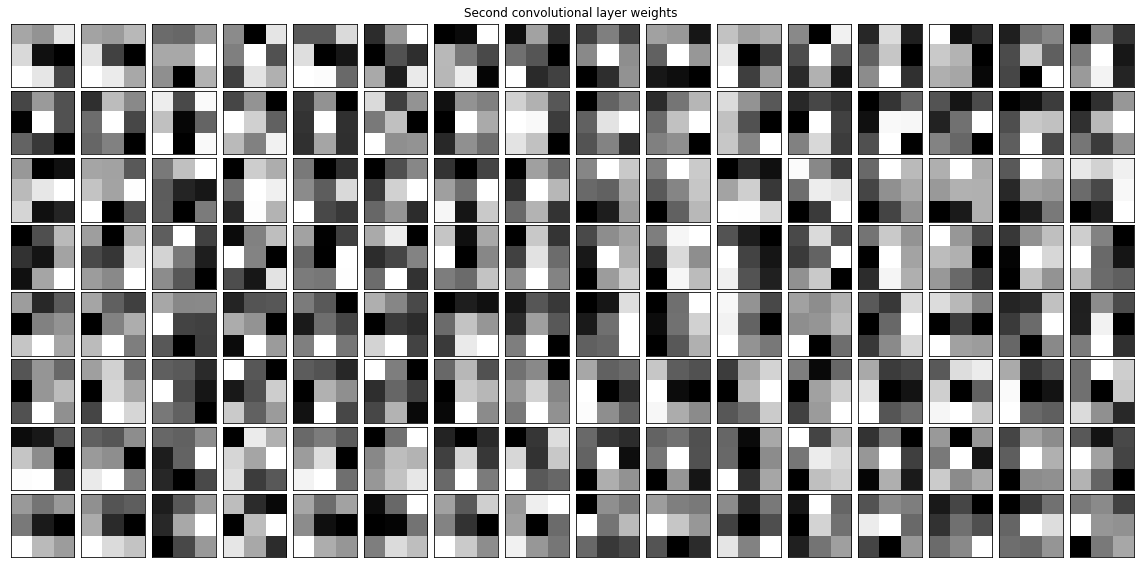

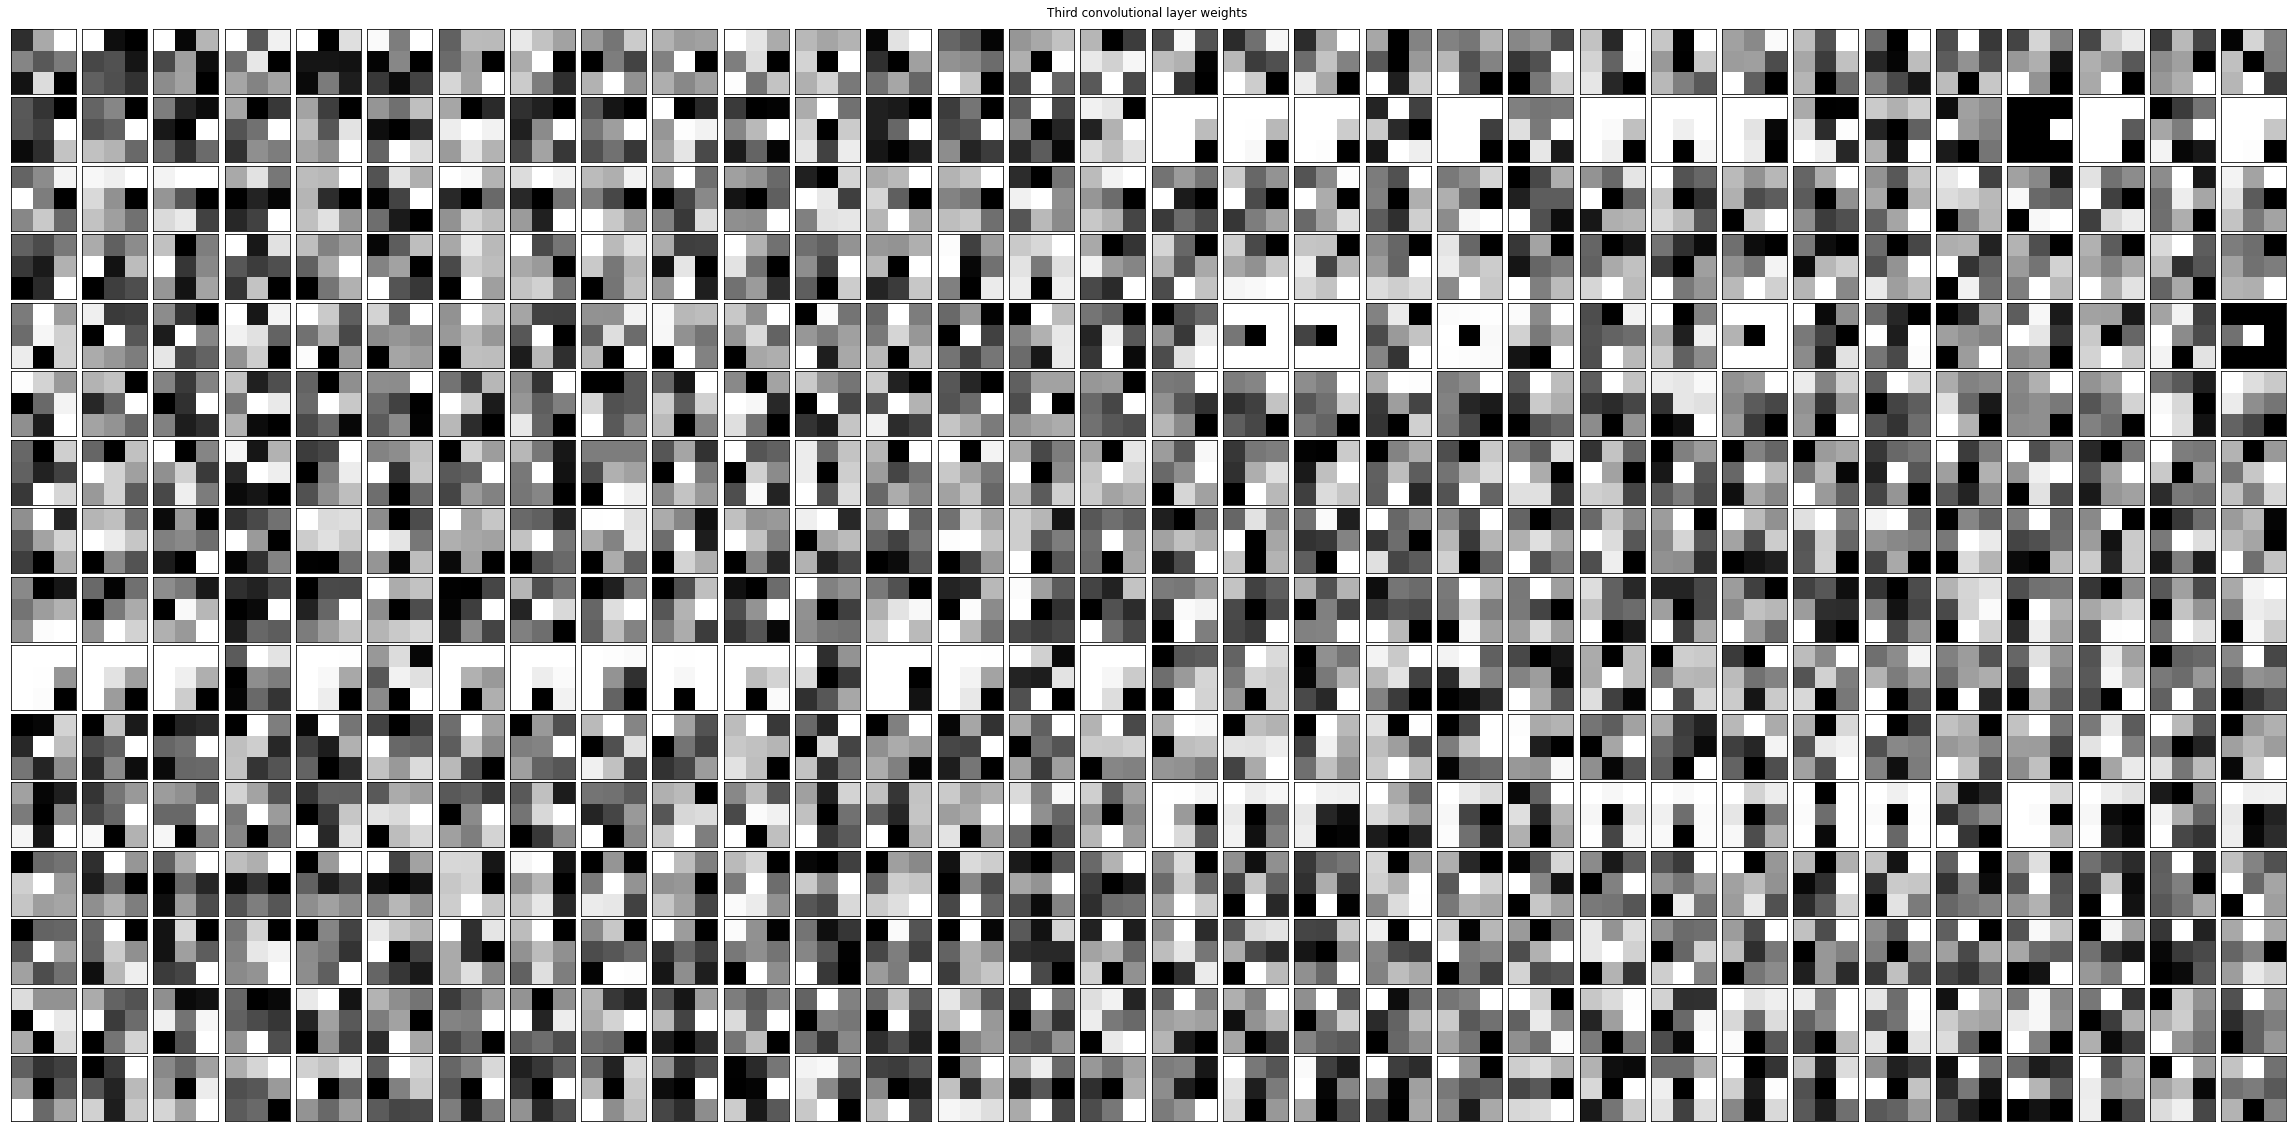

In [42]:

plot_nchw_data(cnet.conv_layers.conv1.weight.data.cpu().numpy(), 8, 1, 'First convolutional layer weights')
plot_nchw_data(cnet.conv_layers.conv2.weight.data.cpu().numpy(), 16, 8, 'Second convolutional layer weights')
plot_nchw_data(cnet.conv_layers.conv3.weight.data.cpu().numpy(), 32, 16, 'Third convolutional layer weights')

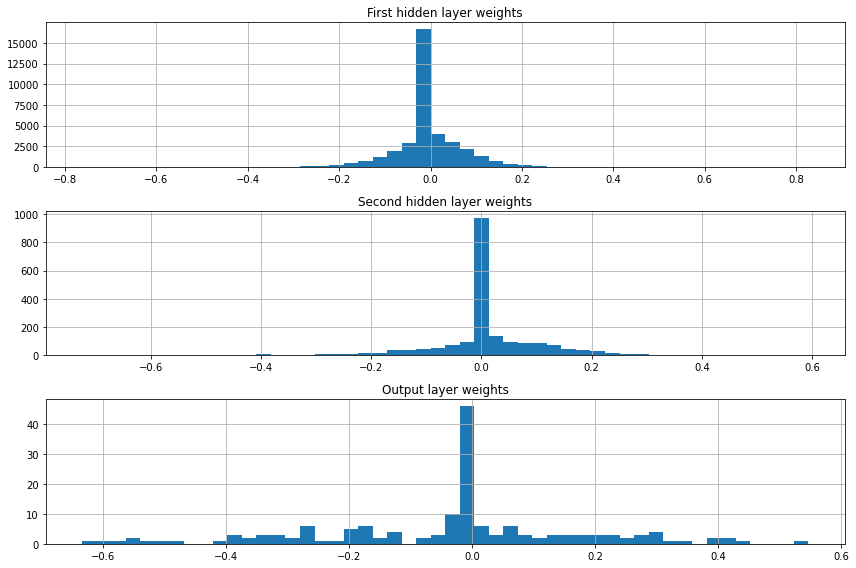

In [43]:
cnet.o_act = nn.Sigmoid()
h1_w = cnet.lin_layers.lin1.weight.data.cpu().numpy()
h2_w =  cnet.lin_layers.lin2.weight.data.cpu().numpy()
out_w = cnet.out.weight.data.cpu().numpy()

# Weights histogram
fig, axs = plt.subplots(3, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights')
axs[2].hist(out_w.flatten(), 50)
axs[2].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

### Activations

Text(0.5, 1.0, 'coat')

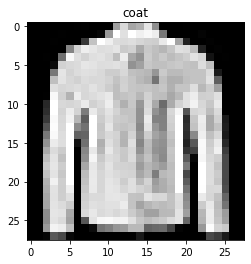

In [32]:
idx = 50

pic = test_dataset[idx][0].unsqueeze(0).to(device)

label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']
label = label_names[test_dataset[idx][1]]
plt.figure()
plt.imshow(np.array(pic.squeeze().cpu()), cmap='gist_gray')
plt.title(label)


In [33]:
def get_acts(layer, input, output):
  print(layer)
  acts.append(output)



ReLU()


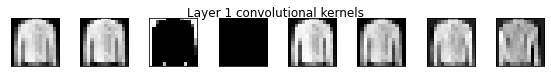

In [34]:
hook_handles = []

layer = cnet.conv_layers.conv_act1
hook_handles.append(layer.register_forward_hook(get_acts))

# Evaluate output
cnet.eval()
with torch.no_grad():
    acts = []
    out = cnet(pic)

# Analyze intermediate outputs
for layer_num, act in enumerate(acts):
    act = act.cpu().data.numpy()
    # Plot
    plot_nchw_data(act,8, 1, title='Layer 1 convolutional kernels' )
    
for hook_handle in hook_handles:
  hook_handle.remove()

ReLU()


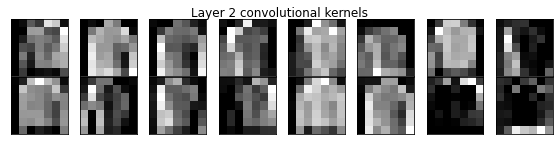

In [35]:
hook_handles = []

layer = cnet.conv_layers.conv_act2
hook_handles.append(layer.register_forward_hook(get_acts))

# Evaluate output
cnet.eval()
with torch.no_grad():
    acts = []
    out = cnet(pic)

# Analyze intermediate outputs
for layer_num, act in enumerate(acts):
    act = act.cpu().data.numpy()
    # Plot
    plot_nchw_data(act, 8, 2, title='Layer 2 convolutional kernels' )
    
for hook_handle in hook_handles:
  hook_handle.remove()

ReLU()


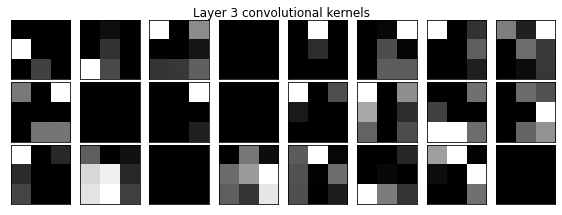

In [36]:
hook_handles = []

layer = cnet.conv_layers.conv_act3
hook_handles.append(layer.register_forward_hook(get_acts))

# Evaluate output
cnet.eval()
with torch.no_grad():
    acts = []
    out = cnet(pic)

# Analyze intermediate outputs
for layer_num, act in enumerate(acts):
    act = act.cpu().data.numpy()
    # Plot
    plot_nchw_data(act, 8, 3, title='Layer 3 convolutional kernels' )
    
for hook_handle in hook_handles:
  hook_handle.remove()

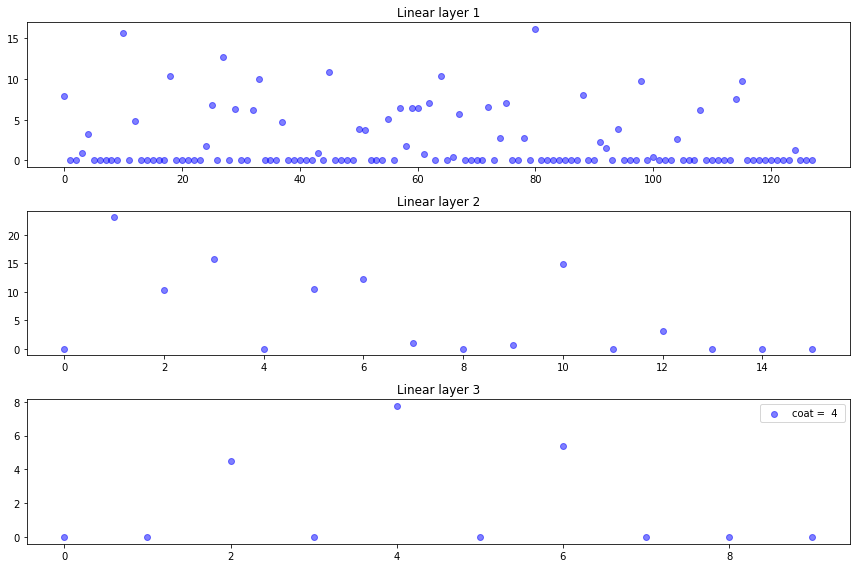

In [37]:
#define a hook for each layer

def get_activation1(layer, input, output):
    global activation1 # define global variable in which to store the activations.
    activation1 = torch.relu(output)

hook_handle1 = cnet.lin_layers.lin_act1.register_forward_hook(get_activation1)

def get_activation2(layer, input, output):
    global activation2 # define global variable in which to store the activations.
    activation2 = torch.relu(output)

hook_handle2 =  cnet.lin_layers.lin_act2.register_forward_hook(get_activation2)

def get_activation3(layer, input, output):
    global activation3 # define global variable in which to store the activations.
    activation3 = torch.relu(output)

hook_handle3 = cnet.out.register_forward_hook(get_activation3)

# evaluate the net
cnet.to(device)
cnet.eval()
with torch.no_grad():
    y = cnet(pic).to(device)

    a1 = activation1.cpu().numpy()
    a2 = activation2.cpu().numpy()
    a3 = activation3.cpu().numpy()


a_s = [a1,a2,a3]

# remove hooks
hook_handle1.remove()
hook_handle2.remove()
hook_handle3.remove()

#plot activations
fig, axs = plt.subplots(3,1, figsize=(12,8))
for i,a in enumerate(a_s):
  axs[i].scatter(np.arange(len(a[0])), a,label=f'{label} =  {test_dataset[idx][1]} ',color='blue', alpha=0.5)
  axs[i].set_title(f'Linear layer {i + 1}')


plt.legend()

fig.tight_layout()



## Activation maximization

In [44]:
print(cnet)

Conv_net(
  (conv_layers): Sequential(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv_act1): ReLU()
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv_act2): ReLU()
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (conv_act3): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lin_layers): Sequential(
    (lin1): Linear(in_features=288, out_features=128, bias=True)
    (lin_act1): ReLU()
    (lin2): Linear(in_features=128, out_features=16, bias=True)
    (lin_act2): ReLU()
  )
  (out): Linear(in_features=16, out_features=10, bias=True)
  (o_act): Sigmoid()
)


In [45]:
# We now freeze the parameters of our pretrained model
for param in cnet.parameters():
    param.requires_grad_(False)
activation = {}
hook_handle = cnet.out.register_forward_hook(create_hook('out'))
# generating the initial image with random pixel values between 0 and 1
H = 28 # height of input image
W = 28 # width of input image
img_tensor, optimizer = random_image(h = H, w = W, device = device, 
                                     requires_grad = True, optimizer = optim.Adam, lr = 0.01)

img_shape:torch.Size([1, 28, 28]), img_dtype: torch.float32


Epoch: 0/10000, activation: 2.4215633869171143


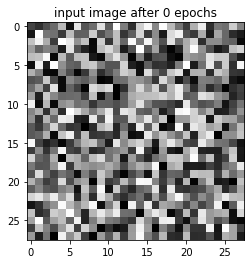

Epoch: 1000/10000, activation: 426.5738220214844


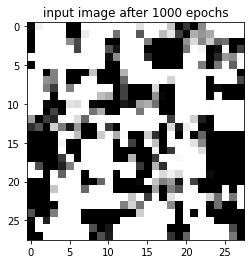

Epoch: 2000/10000, activation: 841.4573364257812


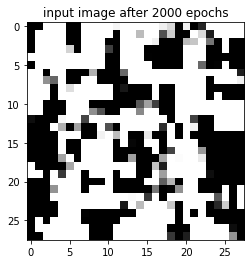

Epoch: 3000/10000, activation: 1244.304443359375


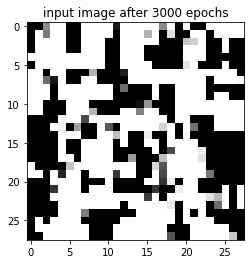

Epoch: 4000/10000, activation: 1648.0604248046875


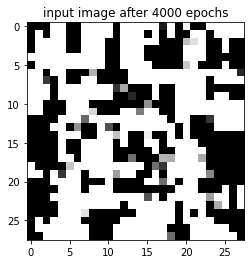

Epoch: 5000/10000, activation: 2054.8466796875


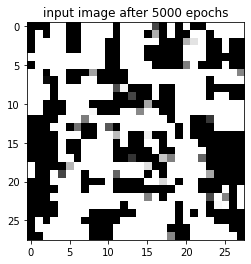

Epoch: 6000/10000, activation: 2460.730224609375


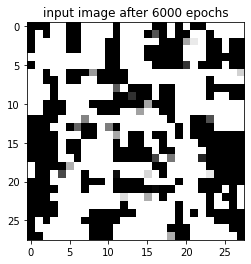

Epoch: 7000/10000, activation: 2867.235595703125


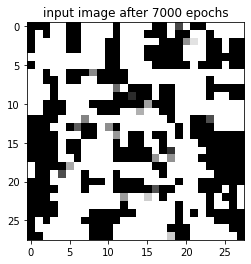

Epoch: 8000/10000, activation: 3274.60107421875


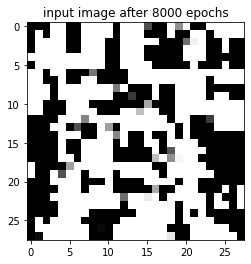

Epoch: 9000/10000, activation: 3682.65087890625


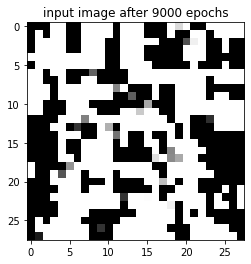

In [46]:
cnet.eval()
cnet.o_act = nn.Identity()
num_epochs = 10000
display_every = 1000
unit_idx = 6 # unit of the convolution layer that we wish to visualize

for epoch in range(num_epochs):
    
    optimizer.zero_grad()
    cnet(img_tensor.unsqueeze(0))
    layer = activation['out']
    loss = -layer[0, unit_idx].mean() 
    loss.backward()
    optimizer.step()

    
    if epoch % display_every == 0:
        print('Epoch: {}/{}, activation: {}'.format(epoch, num_epochs, -loss))
        plt.imshow((image_converter(img_tensor)).squeeze(), cmap='gist_gray')
        plt.title('input image after {} epochs'.format(epoch))
        plt.show()

hook_handle.remove()

In [47]:
y = torch.softmax(cnet(img_tensor.unsqueeze(0)), dim = 1)
y = y.squeeze().detach().cpu().numpy()
cnet.o_act = nn.Sigmoid()
for i,yv in enumerate(y):
  print(f'{i}: {yv}')

0: 0.0
1: 0.0
2: 0.0
3: 0.0
4: 0.0
5: 0.0
6: 1.0
7: 0.0
8: 0.0
9: 0.0


# Optimization


Tuning the networks in order to get better performance

In [48]:
class Conv_net_d(Conv_net):
  '''
  Adds a Dropout 
  '''

  def __init__(self, *args, dropouts_probabilities=[], **kwargs):
    super().__init__(**kwargs)
    
    self.d_od = OrderedDict()

    i = 0
    for k,l in self.lin_od.items():
      if not k.startswith('lin_act') and i < len(dropouts_probabilities):
        self.d_od.update({f'dropout{i+1}': nn.Dropout(dropouts_probabilities[i])})
        i += 1
      self.d_od.update({k: l})

    self.lin_layers = nn.Sequential(self.d_od)

In [49]:
channels = [8,16,32]
kernel_sizes = [3,3,3]
strides = [2,2,2]
paddings = [1,1,0]

dropout_probabilities = [0.5,0.5]
Nhs = [128, 16]

dnet = Conv_net_d(dropouts_probabilities=dropout_probabilities,channels=channels, kernel_sizes=kernel_sizes, strides=strides, paddings=paddings,
             Nhs=Nhs).to(device)

print(dnet)

optimizer = optim.Adam(dnet.parameters(),lr=0.001,weight_decay=1e-4)

loss_function = nn.CrossEntropyLoss()

train_batch_size = 256
val_batch_size = 256

patience = 10

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=0)


trainer = Training_es(patience=patience,net=dnet,optimizer=optimizer,loss_function=loss_function,
                    train_dataloader=train_dataloader,val_dataloader=None)

Conv_net_d(
  (conv_layers): Sequential(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv_act1): ReLU()
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv_act2): ReLU()
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (conv_act3): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lin_layers): Sequential(
    (dropout1): Dropout(p=0.5, inplace=False)
    (lin1): Linear(in_features=288, out_features=128, bias=True)
    (lin_act1): ReLU()
    (dropout2): Dropout(p=0.5, inplace=False)
    (lin2): Linear(in_features=128, out_features=16, bias=True)
    (lin_act2): ReLU()
  )
  (out): Linear(in_features=16, out_features=10, bias=True)
  (o_act): Identity()
)


  0%|          | 0/100 [00:00<?, ?it/s]

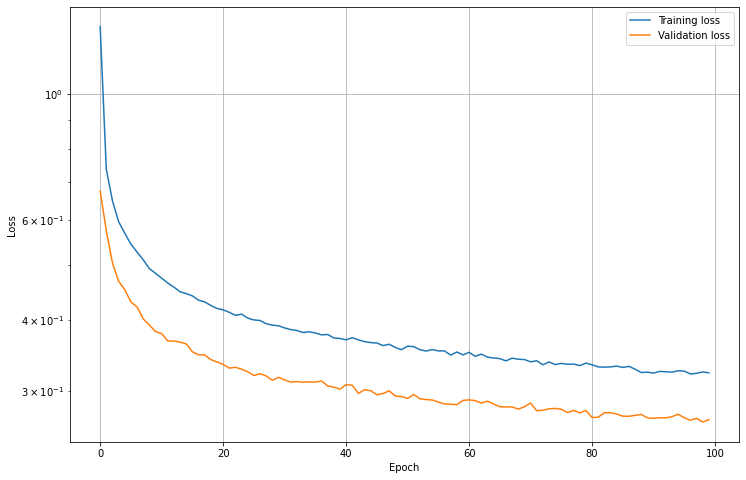

Average traininig  loss in the last 10 epochs: 0.3240
Average validation loss in the last 10 epochs: 0.2689


In [ ]:
#trainer.train(100,verbose= False)

#trainer.plot_losses()

It can be observed that only introducing a little of regularization helps and improve a lot the results w.r.t the losses decrease a lot

In [ ]:
## K-fold TEST ##

k = 3

# net params
net_type = Conv_net_d

net_params = {'channels': [8,16,32], 'kernel_sizes': [3,3,3], 'strides': [2,2,2], 'paddings': [1,1,0],
              'dropouts_probabilities': [0.5,0.5], 'Nhs': [128, 16]}

# optimizer params
optimizer_type = optim.Adam
optimizer_params = {'lr': 0.001}

loss_function = nn.CrossEntropyLoss()

train_batch_size = 256

trainer_type = Training_es
trainer_additional_params = {'patience': 10, 'best_vl': 0.1}


# KFold

kf = KFoldCrossValidator(k, shuffle=True, all_train_dataset=all_train_dataset, net_type=net_type, net_params=net_params,
                         optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                         train_batch_size=train_batch_size, trainer_type=trainer_type, trainer_additional_params=trainer_additional_params)

_,_ =kf.run(1)

Network initialized
Network initialized
Network initialized


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]



Results
### Average train loss: 1.4128376245498657
### Average validation loss: 0.7502515316009521




In [ ]:

k = 5
runs = 2

net_type = Conv_net_d
optimizer_type = optim.Adam

name = 'classification - best net'
loss_function = nn.CrossEntropyLoss()

train_batch_size = 256

trainer_type = Training_es
trainer_additional_params = {'patience': 10} # no checkpoint to speed up the training

def objective(trial):


  # sample hypermarameters
  
  # convolutional layers part
  n_c_layers = trial.suggest_int('ncl', 2, 4)
  
  channels = []
  kernel_sizes = []
  strides = []
  paddings = []

  for j in range(n_c_layers):
    channels.append(trial.suggest_int(f'ch{j+1}', 4, 8*2**j))
    kernel_sizes.append(trial.suggest_int(f'ks{j+1}', 2, 6))
    strides.append(trial.suggest_int(f'stride{j+1}', 1, 4))
    paddings.append(trial.suggest_int(f'padding{j+1}', 0, 1))


  # linear layers part
  p1 = trial.suggest_float('p1', 0, 0.7)
  p2 = trial.suggest_float('p2', 0, 0.7)
  Nh1 = trial.suggest_int('Nh1', 16, 256)
  Nh2 = trial.suggest_int('Nh2', 4, 128)

  # optimizer part
  lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
  weight_decay = trial.suggest_float('weight_decay', 1e-7,1e-1, log=True)

  net_params = {'channels': channels, 'kernel_sizes': kernel_sizes, 'strides': strides, 'paddings': paddings,
              'dropouts_probabilities': [p1,p2], 'Nhs': [Nh1, Nh2]}
  
  optimizer_params = {'lr': lr, 'weight_decay': weight_decay}



  try:
    kf = KFoldCrossValidator(k, n_runs=runs, shuffle=True, all_train_dataset=all_train_dataset, net_type=net_type, net_params=net_params,
                          optimizer_type=optimizer_type, optimizer_params=optimizer_params, loss_function=loss_function,
                          train_batch_size=train_batch_size, trainer_type=trainer_type, trainer_additional_params=trainer_additional_params)

    avg_tr_loss, avg_val_loss = kf.run(100)
  except:
    raise optuna.TrialPruned() # to stop trials that produce invalid nets

  


  # dictionary with all the hyperparameters and performance of the net
  hyper_dict = dict(**net_params, **optimizer_params, **{'avg_tr_loss': avg_tr_loss, 'avg_val_loss': avg_val_loss})




  return np.mean([e.best_vl for e in kf.trainers]) 


study = optuna.create_study(study_name=name, direction="minimize")

[I 2022-02-03 10:18:44,802] A new study created in memory with name: classification - best net


In [ ]:
study.optimize(objective, n_trials=50)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

Network initialized
Network initialized


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 10:18:44,953] Trial 0 pruned. 


Network initialized
Network initialized


/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 10:18:45,097] Trial 1 pruned. 


Network initialized
Network initialized


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 10:45:40,965] Trial 2 finished with value: 0.41541165113449097 and parameters: {'ncl': 3, 'ch1': 6, 'ks1': 3, 'stride1': 1, 'padding1': 1, 'ch2': 16, 'ks2': 3, 'stride2': 4, 'padding2': 1, 'ch3': 8, 'ks3': 4, 'stride3': 3, 'padding3': 1, 'p1': 0.09660218184104906, 'p2': 0.6723291952911091, 'Nh1': 205, 'Nh2': 101, 'lr': 0.0002468565694571706, 'weight_decay': 0.00160093149097596}. Best is trial 2 with value: 0.41541165113449097.




Results
### Average train loss: 0.48657655715942383
### Average validation loss: 0.41937220096588135


Network initialized
Network initialized


/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 10:45:41,111] Trial 3 pruned. 


Network initialized
Network initialized


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 10:45:41,245] Trial 4 pruned. 


Network initialized
Network initialized


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 10:45:41,373] Trial 5 pruned. 


Network initialized
Network initialized


/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 10:45:41,513] Trial 6 pruned. 


Network initialized
Network initialized


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 10:45:41,643] Trial 7 pruned. 


Network initialized
Network initialized


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 11:03:40,697] Trial 8 finished with value: 0.5337737798690796 and parameters: {'ncl': 2, 'ch1': 8, 'ks1': 2, 'stride1': 2, 'padding1': 0, 'ch2': 4, 'ks2': 3, 'stride2': 4, 'padding2': 0, 'p1': 0.22516258356488641, 'p2': 0.36586684035674344, 'Nh1': 245, 'Nh2': 78, 'lr': 0.0004471721768033481, 'weight_decay': 0.0008558853179762165}. Best is trial 2 with value: 0.41541165113449097.


---> Early stopping


Results
### Average train loss: 0.6274577379226685
### Average validation loss: 0.5460996627807617


Network initialized
Network initialized


/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 11:03:40,844] Trial 9 pruned. 


Network initialized
Network initialized


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 11:12:35,694] Trial 10 finished with value: 2.302647590637207 and parameters: {'ncl': 3, 'ch1': 6, 'ks1': 2, 'stride1': 3, 'padding1': 1, 'ch2': 16, 'ks2': 4, 'stride2': 3, 'padding2': 0, 'ch3': 4, 'ks3': 5, 'stride3': 3, 'padding3': 1, 'p1': 0.14631397193619533, 'p2': 0.6577450030961022, 'Nh1': 22, 'Nh2': 125, 'lr': 1.274774094803476e-05, 'weight_decay': 0.05237298576691065}. Best is trial 2 with value: 0.41541165113449097.


---> Early stopping


Results
### Average train loss: 2.3027796745300293
### Average validation loss: 2.3026583194732666


Network initialized
Network initialized


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 11:12:35,845] Trial 11 pruned. 


Network initialized
Network initialized


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 11:36:53,053] Trial 12 finished with value: 0.7498366832733154 and parameters: {'ncl': 2, 'ch1': 5, 'ks1': 2, 'stride1': 3, 'padding1': 0, 'ch2': 9, 'ks2': 3, 'stride2': 4, 'padding2': 0, 'p1': 0.3725503524758232, 'p2': 0.2577798116282287, 'Nh1': 176, 'Nh2': 117, 'lr': 8.54797438992564e-05, 'weight_decay': 4.8963576083938134e-05}. Best is trial 2 with value: 0.41541165113449097.




Results
### Average train loss: 0.8515114784240723
### Average validation loss: 0.7579271793365479


Network initialized
Network initialized


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 11:58:35,591] Trial 13 pruned. 


Network initialized
Network initialized


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 11:58:42,397] Trial 14 pruned. 


Network initialized
Network initialized


/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 11:58:42,571] Trial 15 pruned. 


Network initialized
Network initialized


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 11:58:42,737] Trial 16 pruned. 


Network initialized
Network initialized


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 11:58:42,905] Trial 17 pruned. 


Network initialized
Network initialized


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 11:58:43,072] Trial 18 pruned. 


Network initialized
Network initialized


  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 12:09:17,683] Trial 19 finished with value: 2.3027255535125732 and parameters: {'ncl': 3, 'ch1': 7, 'ks1': 3, 'stride1': 2, 'padding1': 1, 'ch2': 7, 'ks2': 3, 'stride2': 3, 'padding2': 1, 'ch3': 17, 'ks3': 5, 'stride3': 2, 'padding3': 1, 'p1': 0.4907255155208671, 'p2': 0.5939011712450979, 'Nh1': 195, 'Nh2': 18, 'lr': 0.000256268313476114, 'weight_decay': 0.01678650458237301}. Best is trial 2 with value: 0.41541165113449097.


---> Early stopping


Results
### Average train loss: 2.302586555480957
### Average validation loss: 2.302741050720215


Network initialized
Network initialized


/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 12:09:17,876] Trial 20 pruned. 


Network initialized
Network initialized


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 12:32:50,967] Trial 21 pruned. 


Network initialized
Network initialized


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 12:34:11,616] Trial 22 pruned. 


Network initialized
Network initialized


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 12:34:12,424] Trial 23 pruned. 


Network initialized
Network initialized


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-02-03 12:34:12,659] Trial 24 pruned. 


Network initialized
Network initialized


  0%|          | 0/100 [00:00<?, ?it/s]

##  Train and test best net

In [ ]:
#study.best_params

In [50]:
channels = [4,15,19]
kernel_sizes = [3,3,4]
strides = [3,1,2]
paddings = [0,1,1]

dropout_probabilities = [0.4726,0.6960]
Nhs = [129, 69]

dnet = Conv_net_d(dropouts_probabilities=dropout_probabilities,channels=channels, kernel_sizes=kernel_sizes, strides=strides, paddings=paddings,
             Nhs=Nhs).to(device)
optimizer = optim.Adam(dnet.parameters(),lr=0.000429,weight_decay=5.053e-05)

loss_function = nn.CrossEntropyLoss()

train_batch_size = 256
val_batch_size = 256
patience = 5

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False, num_workers=0)


trainer = Training_es(patience = patience, net=dnet,optimizer=optimizer,loss_function=loss_function,
                    train_dataloader=train_dataloader,val_dataloader=val_dataloader)

  0%|          | 0/100 [00:00<?, ?it/s]

---> Early stopping


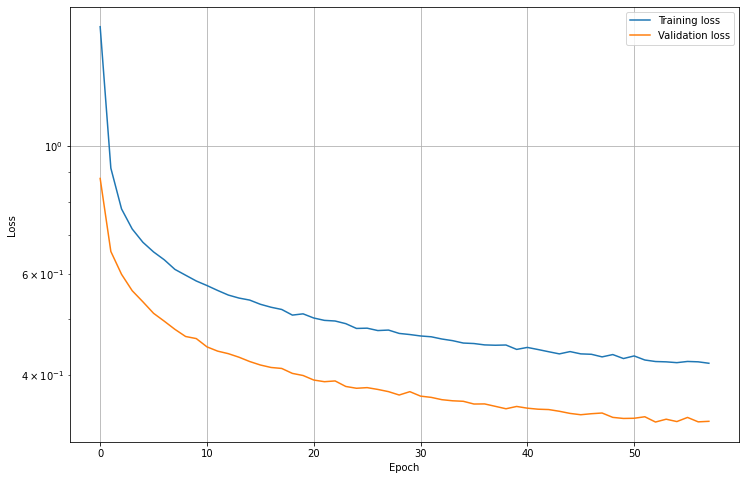

Average traininig  loss in the last 10 epochs: 0.4244
Average validation loss in the last 10 epochs: 0.3348


In [ ]:
#trainer.train(100,verbose= False)

#trainer.plot_losses()


In [51]:
## Saving model ##
#torch.save(trainer.net.state_dict(), 'dropout_cnet.pth')

## Load model ##
dnet.load_state_dict(torch.load('dropout_cnet.pth'))

<All keys matched successfully>

Network accuracy: 0.8637


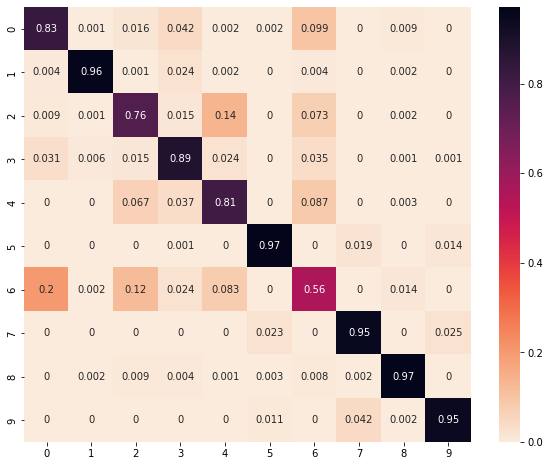

In [52]:
test_dataset.transform = train_transform
test_dataloader = DataLoader(test_dataset,batch_size=256,shuffle=False,num_workers=0)
net_outputs = np.array([])
labels = np.array([])

dnet.eval()
with torch.no_grad():
  for batch in test_dataloader:
    out = torch.argmax(dnet(batch[0].to(device)), dim=1).cpu().numpy()
    label = batch[1].squeeze().cpu().numpy()

    net_outputs = np.concatenate([net_outputs, out])
    labels = np.concatenate([labels, label])

net_outputs = np.array(net_outputs, dtype=int)
labels = np.array(labels, dtype=int)
cm = metrics.confusion_matrix(labels, net_outputs)
# Show the confusion matrix
fig = plt.figure(figsize=(10,8))
sn.heatmap(cm/np.sum(cm)*10, annot=True, cmap='rocket_r')
accuracy = np.mean(net_outputs == labels)

print('Network accuracy:', accuracy)